# Mental health disorders in written posts


Import the necessary libraries.

In [3]:
import re
import time
import spacy
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

Continue by loading the data from spaCy (in order to install and load spacy, follow this guide: https://spacy.io/usage).

In [4]:
nlp = spacy.load('en_core_web_lg')
stop_words_spacy = nlp.Defaults.stop_words

### Data handling

Load data and plot the distribution of the disorders encountered in the dataset, labeled with the following numbers:

0 = Stress;
1 = Depression;
2 = Bipolar disorder;
3 = Personality disorder;
4 = Anxiety.

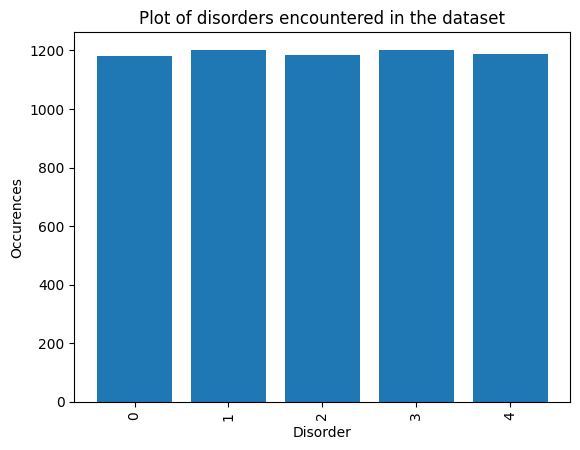

In [7]:
data = pd.read_csv("posts.csv", delimiter=",", dtype={'target': int})

labels_unique, counts = np.unique(data['target'], return_counts=True)

plt.bar(labels_unique, counts)
plt.xlabel('Disorder')
plt.xticks(rotation=90)
plt.ylabel('Occurences')
plt.title('Plot of disorders encountered in the dataset')
plt.show()

Concat the title of each post to the text, then split data into train and test, remove NaNs.

In [8]:
data['combined'] = data['title'] + " " + data['text']

# data, _ = train_test_split(data, test_size=0.9)               # when testing the code, use this line to do a sanity check on 10% of data
train_data, test_data = train_test_split(data, test_size=0.1)

X_train = train_data['combined']
y_train = train_data['target']
X_test = test_data['combined']
y_test = test_data['target']


X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Ensure y_train matches X_train

X_test = X_test.dropna()
y_test = y_test[X_test.index]  # Ensure y_test matches X_test

### Class used for preprocessing the text

In [9]:
class TextFeaturesExtractor:
    def __init__(self, max_features=100, filter_stop_words=True, use_lemmas=True, explain_emojis=True):
        self.max_features = max_features
        self.filter_stop_words = filter_stop_words
        self.use_lemmas = use_lemmas
        self.explain_emojis = explain_emojis


    def replace_emojis(self, text):
        '''
        replace_emojis("I'm so 😊!") => "I'm so smiling_face_with_smiling_eyes!"
        '''
        return emoji.demojize(text, delimiters=("", ""))


    def preprocess_text(self, text):
        '''
        Method used for "cleaning" the text, reducing it only to sequences of letters separated by a space.
        Implicitly it will replace emojis with their descriptions.
        '''
        if self.explain_emojis:
            text = self.replace_emojis(text)
        text = text.lower()
        text = re.sub(r'\d+', ' ', text)        # remove digits
        text = re.sub(r'[^\w\s]', ' ', text)    # remove characters different than words and whitespaces
        text = re.sub(r'\s+', ' ', text)        # reduce whitespaces sequences to just one space
        text = text.strip()                     # remove trailing whitespaces
        return text


    def tokenize_text(self, text):
        '''
        Method that takes a text and returnes a list with the lemmas of each word (and excludes the stop_words).
        Implicitly it will remove stop_words and bring every word to its lemma.
        '''
        text = nlp(text)
        if self.use_lemmas:
            text = [word.lemma_ for word in text]
        else:
            text = [word.text for word in text]

        if self.filter_stop_words:
            text = [word.lower() for word in text if word not in stop_words_spacy]
        else:
            text = [word.lower() for word in text]

        return text


    def cv(self, X_train, X_test):
        cv = CountVectorizer(
            preprocessor=self.preprocess_text,
            tokenizer=self.tokenize_text,
            token_pattern=None,
            max_features=self.max_features,
            binary=False,
        )

        cv.fit(X_train)

        X_train_cv = cv.transform(X_train)
        X_test_cv = cv.transform(X_test)

        return X_train_cv, X_test_cv


    def tf(self, X_train, X_test):
        tf = TfidfVectorizer(
            preprocessor=self.preprocess_text,
            tokenizer=self.tokenize_text,
            token_pattern=None,
            max_features=self.max_features,
            binary=False,
            max_df=100,
            min_df=10
        )

        tf.fit(X_train)

        X_train_tf = tf.transform(X_train)
        X_test_tf = tf.transform(X_test)

        return X_train_tf, X_test_tf

# Start training and tuning

Method used for printing results.

In [10]:
def print_results(actual_labels, predicted_labels):
    accuracy = metrics.accuracy_score(actual_labels, predicted_labels)
    print("Accuracy: ", accuracy)

Method used for displaying a confusion matrix.

In [11]:
def plot_confusion_matrics(actual_labels, predicted_labels, title):
    labels = np.union1d(np.unique(actual_labels), np.unique(predicted_labels))

    accuracy = metrics.accuracy_score(actual_labels, predicted_labels)

    confusion_matrix = metrics.confusion_matrix(actual_labels, predicted_labels)
    confusion_matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
    confusion_matrix_display.plot()
    plt.title(f"{title}\nAccuracy: {accuracy}")
    plt.show()
    plt.savefig(f"resulting_plots/{title}.png")
    plt.clf()

## Models used

### Naive Bayes

This model was used in the beginning, in order to determin the best preprocessor.

In [ ]:
def naive_bayes(X_train, X_test, y_train, y_test):

    X_train = X_train.toarray()
    X_test = X_test.toarray()

    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)

    predicted = mnb.predict(X_test)

    print_results(y_test, predicted)
    # plot_confusion_matrics(y_test, predicted, 'naive_bayes')
    return mnb

### Grid search for best preprocessing combo

Grid search: find the best preproccessing combo.

In [ ]:
for max_features in [100, 500, 1000, 2000, 5000]:
    for filter_stop_words in [True, False]:
        for use_lemmas in [True, False]:
            for explain_emojis in [True, False]:

                tokenizer = TextFeaturesExtractor(max_features, filter_stop_words, use_lemmas, explain_emojis)

                X_train_tf, X_test_tf = tokenizer.tf(X_train, X_test)
                print(f"TFIDF, {max_features} features, stop words removed: {filter_stop_words}, lemmas used: {use_lemmas}, emojis explained: {explain_emojis},", end=' ')
                mnb = naive_bayes(X_train_tf, X_test_tf, y_train, y_test)

                X_train_cv, X_test_cv = tokenizer.cv(X_train, X_test)
                print(f"CV, {max_features} features, stop words removed: {filter_stop_words}, lemmas used: {use_lemmas}, emojis explained: {explain_emojis},", end=' ')
                mnb = naive_bayes(X_train_cv, X_test_cv, y_train, y_test)

TFIDF, 100 features, stop words removed: True, lemmas used: True, emojis explained: True, Accuracy:  0.3415492957746479
CV, 100 features, stop words removed: True, lemmas used: True, emojis explained: True, Accuracy:  0.6267605633802817
TFIDF, 100 features, stop words removed: True, lemmas used: True, emojis explained: False, Accuracy:  0.3415492957746479
CV, 100 features, stop words removed: True, lemmas used: True, emojis explained: False, Accuracy:  0.6285211267605634
TFIDF, 100 features, stop words removed: True, lemmas used: False, emojis explained: True, Accuracy:  0.3257042253521127
CV, 100 features, stop words removed: True, lemmas used: False, emojis explained: True, Accuracy:  0.6285211267605634
TFIDF, 100 features, stop words removed: True, lemmas used: False, emojis explained: False, Accuracy:  0.3274647887323944
CV, 100 features, stop words removed: True, lemmas used: False, emojis explained: False, Accuracy:  0.6285211267605634
TFIDF, 100 features, stop words removed: Fal

The best accuracy obtained above was 0.79, when we used 5000 features, revoved the stopwords, lemmatized the words and transformed the emojis into text.

### We found the best preprocessing combo, we will use it for testing different models

In [13]:
best_tokenizer = TextFeaturesExtractor(max_features=5000, filter_stop_words=True, use_lemmas=True, explain_emojis=True)
X_train_cv, X_test_cv = best_tokenizer.cv(X_train, X_test)

### Random Forest

Accuracy:  0.8405017921146953


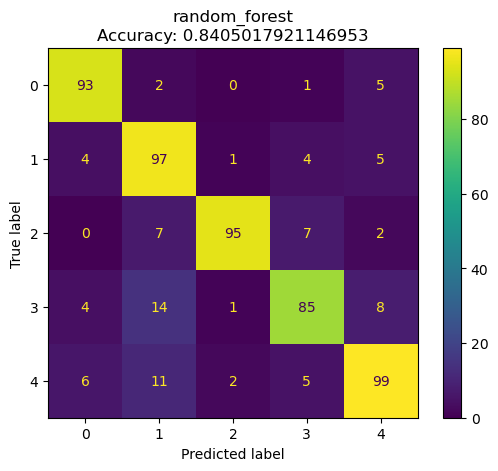

<Figure size 640x480 with 0 Axes>

In [ ]:
def random_forest(X_train, X_test, y_train, y_test):

    X_train = X_train.toarray()
    X_test = X_test.toarray()

    random_forest_classifier = RandomForestClassifier()
    random_forest_classifier.fit(X_train, y_train)

    predicted = random_forest_classifier.predict(X_test)

    print_results(y_test, predicted)
    plot_confusion_matrics(y_test, predicted, 'random_forest')

    return random_forest_classifier

rf = random_forest(X_train_cv, X_test_cv, y_train, y_test)

### SVC

Accuracy:  0.6953405017921147


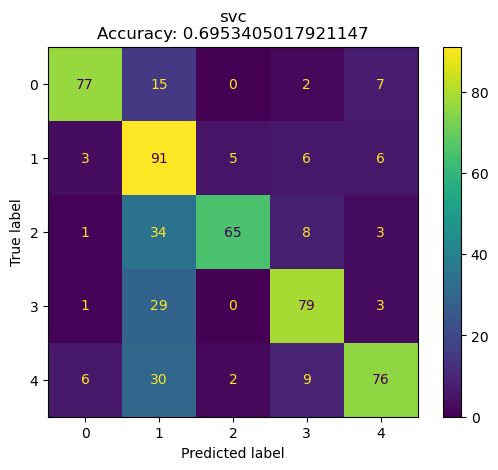

<Figure size 640x480 with 0 Axes>

In [ ]:
def svc_classifier(X_train, X_test, y_train, y_test):

    X_train = X_train.toarray()
    X_test = X_test.toarray()

    svc_classifier = SVC()
    svc_classifier.fit(X_train, y_train)

    predicted = svc_classifier.predict(X_test)

    print_results(y_test, predicted)
    plot_confusion_matrics(y_test, predicted, 'svc')

    return svc_classifier

svc = svc_classifier(X_train_cv, X_test_cv, y_train, y_test)

### GBC

Accuracy:  0.7901234567901234


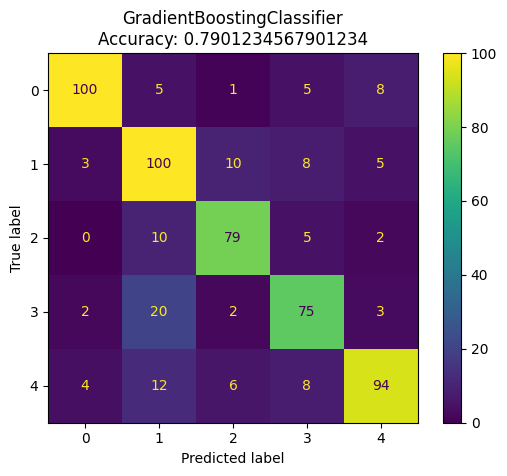

<Figure size 640x480 with 0 Axes>

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
def gbc_classifier(X_train, X_test, y_train, y_test):

    X_train = X_train.toarray()
    X_test = X_test.toarray()

    gbc_classifier = GradientBoostingClassifier()
    gbc_classifier.fit(X_train, y_train)

    predicted = gbc_classifier.predict(X_test)

    print_results(y_test, predicted)
    plot_confusion_matrics(y_test, predicted, 'GradientBoostingClassifier')

    return gbc_classifier

gbc = gbc_classifier(X_train_cv, X_test_cv, y_train, y_test)

### LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7066
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 1739
[LightGBM] [Info] Start training from score -1.637609
[LightGBM] [Info] Start training from score -1.544156
[LightGBM] [Info] Start training from score -1.628467
[LightGBM] [Info] Start training from score -1.642724
[LightGBM] [Info] Start training from score -1.597603
Accuracy:  0.8430335097001763


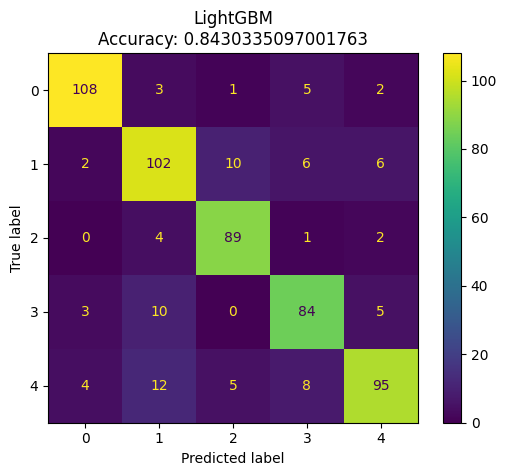

<Figure size 640x480 with 0 Axes>

In [16]:
import lightgbm as lgb
def lgbm_classifier(X_train, X_test, y_train, y_test):

    X_train = X_train.toarray()
    X_test = X_test.toarray()

    lgbm_classifier = lgb.LGBMClassifier()
    lgbm_classifier.fit(X_train, y_train)

    predicted = lgbm_classifier.predict(X_test)

    print_results(y_test, predicted)
    plot_confusion_matrics(y_test, predicted, 'LightGBM')

    return lgbm_classifier

lgbm = lgbm_classifier(X_train_cv, X_test_cv, y_train, y_test)

### XGBoost

Accuracy:  0.8218694885361552


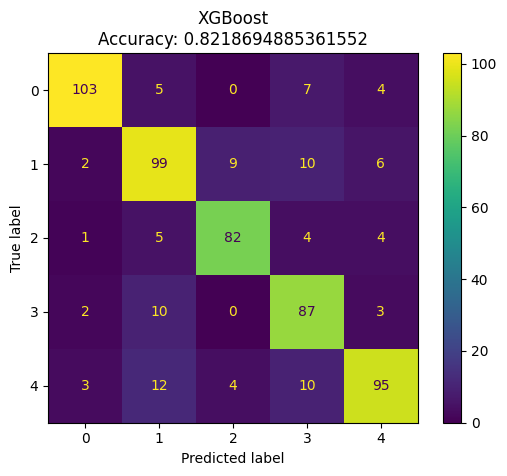

<Figure size 640x480 with 0 Axes>

In [19]:
from xgboost import XGBClassifier
def xgboost_classifier(X_train, X_test, y_train, y_test):

    X_train = X_train.toarray()
    X_test = X_test.toarray()

    xgboost_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgboost_classifier.fit(X_train, y_train)

    predicted = xgboost_classifier.predict(X_test)

    print_results(y_test, predicted)
    plot_confusion_matrics(y_test, predicted, 'XGBoost')

    return xgboost_classifier

xgbc = xgboost_classifier(X_train_cv, X_test_cv, y_train, y_test)